In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [74]:
ft = pd.read_csv('../../data_cleaning/filtered_ft.tsv', sep='\t', index_col=0) 
metadata = pd.read_csv('../../data_cleaning/subsetted_md.tsv', sep='\t', index_col=0)

/tmp/ipykernel_195601/2151176435.py:2: DtypeWarning: Columns (45,48,64,70,71,72,73,113,119,140,142,160,165,167,177,195,198,200,201,224,252,261,265,266,284,285,300,304,305,306,315,316,319,321,325,328,329,341,342,347,351,354,358,361,368,369,370,374,376,380,384,389,390,397,399,407,408,416,428,431,438,443,446,450,455,460,461,462,463,464,465,470,475,481,485,487,493,504,543,549,562,573,582,585,591,598,602,607,611,612,613,637,643,667,687,697,698,707,708,709,720,727,737,739,743,748,760,769,773,806,809,813,840,844,850,852,870,874,891,892,899,910,912,924,925,926,933,936,940,946,953,955,956) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('../../data_cleaning/subsetted_md.tsv', sep='\t', index_col=0)


In [75]:
def rf_classifier(ft, md, col, n_folds, stratified=False): 
    auc_scores = []  # List to store AUCs for each fold
    X = ft.copy()
    md_sub = md.loc[md.index.intersection(X.index)]
    y = md_sub[col]
    
    if stratified: 
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=6) 
        kf_split = skf.split(X, y)
    else: 
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=6)
        kf_split = kf.split(X)
    
    # conversion between index and SampleID
    i_to_id = {i:X.index[i] for i in range(len(X.index))}
    
    full_test = []
    full_preds = []
    # iterate through each of the splits 
    for i, (train_index, test_index) in enumerate(kf_split):
        train_ids = [i_to_id[j] for j in train_index]
        test_ids = [i_to_id[k] for k in test_index]
        
        train_X = X.loc[train_ids]
        train_y = y.loc[train_ids]
        test_X = X.loc[test_ids]
        test_y = y.loc[test_ids] 
        
        label_binarizer = LabelBinarizer().fit(train_y)
        y_onehot_test = label_binarizer.transform(test_y)

        regr = RandomForestClassifier()
        regr.fit(train_X, train_y)
        y_pred = regr.predict_proba(test_X)
        
        fig, ax = plt.subplots(figsize=(6, 6))
        
        full_test.append(y_onehot_test)
        full_preds.append(y_pred) 
        
        for c in y.unique():
            class_of_interest = c
            class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
            RocCurveDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_pred[:, class_id],
                name=f"ROC curve for {c}", 
                ax=ax
            )
        plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
        plt.ylabel('True Positive Rate') 
        plt.xlabel('False Postive Rate')
        plt.title(f'ROC Curve: One to Rest THDMI Cohort - Fold = {i}') 
        plt.legend()
        #save_name = 'results/roc_curve_fold_' + str(i) + '.pdf'
        #plt.savefig(save_name)
    return np.concatenate(full_test), np.concatenate(full_preds)

In [76]:
us_auc = np.mean([.97, .94, .98, .96, .96])
uk_auc = np.mean([.95, .95, .97, .94, .94])
print(us_auc)
print(uk_auc)

0.962
0.95


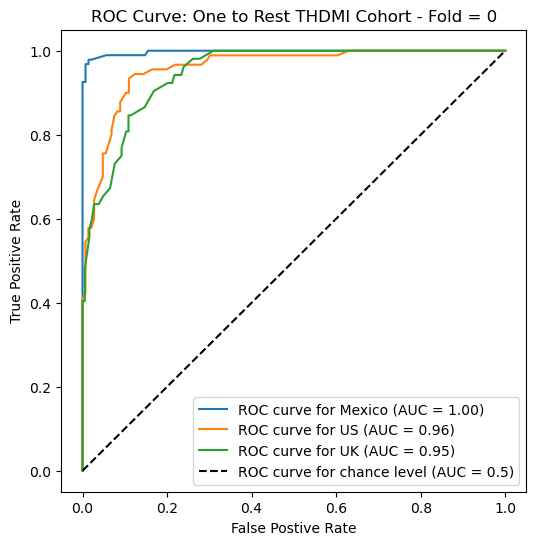

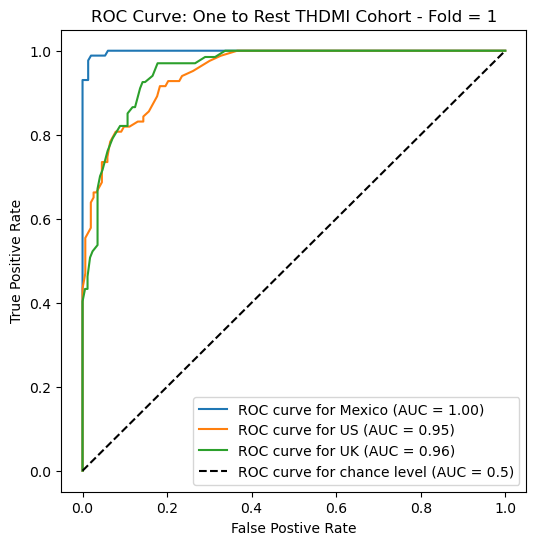

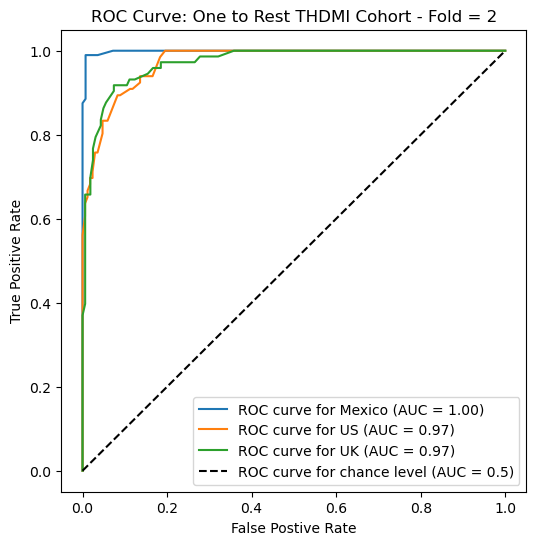

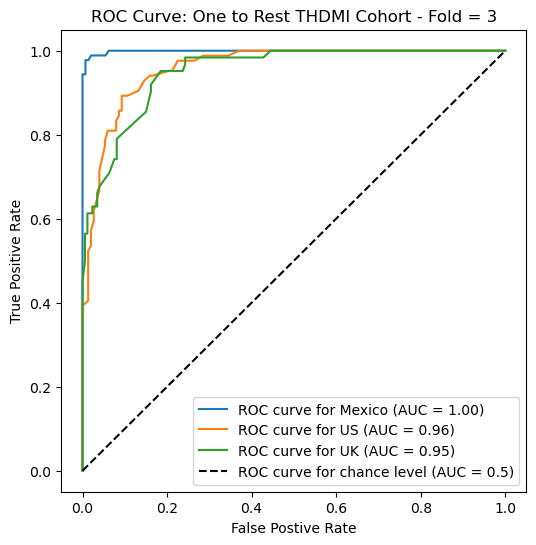

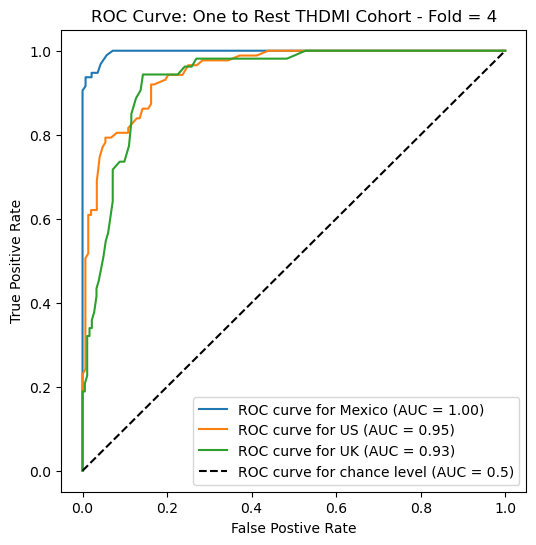

In [77]:
full_test, full_preds = rf_classifier(ft, metadata, 'thdmi_cohort', 5)

In [78]:
results = pd.DataFrame(full_test, columns=['Mexico', 'UK', 'US']).idxmax(axis=1).values
preds = pd.DataFrame(full_preds, columns=['Mexico', 'UK', 'US']).idxmax(axis=1).values

In [79]:
pd.DataFrame(confusion_matrix(results, preds), columns=['Mexico', 'UK', 'US'], index=['Mexico', 'UK', 'US']).to_csv('figure1d_confusion_matrix.csv')

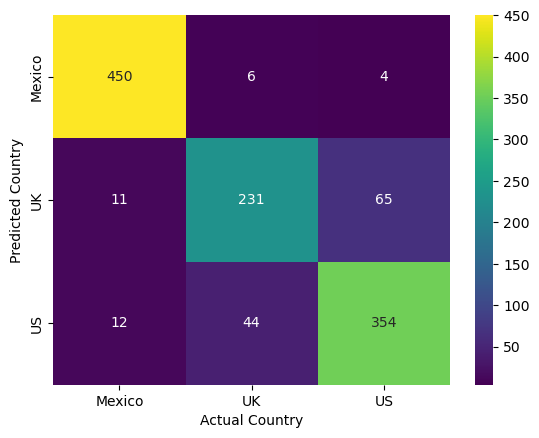

In [80]:
import seaborn as sns

confusion_matrix = pd.read_csv('figure1d_confusion_matrix.csv', index_col=0)
sns.heatmap(confusion_matrix, cmap='viridis', annot=True, fmt=".0f")
plt.ylabel('Predicted Country') 
plt.xlabel('Actual Country')
plt.savefig('../../final_figures/figure1d_confusion_matrix.pdf')